In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import io
import seaborn as sns
import datetime
import math
import time
from scipy import stats

In [2]:
! pip install xgboost
import xgboost as xgb

  Using cached xgboost-1.4.2-py3-none-manylinux2010_x86_64.whl (166.7 MB)


In [6]:
myListings_oneHot_v2 = pd.read_csv('myListings_oneHot_v2.csv')

In [8]:
#removing irrelevant features
myListings_oneHot_v2 = myListings_oneHot_v2.drop(columns = ['description', 'review_scores_rating', 'review_scores_accuracy'\
                        ,'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location'\
                        , 'review_scores_value'])

In [9]:
myListings_oneHot_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9385 entries, 0 to 9384
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      9385 non-null   int64  
 1   id                              9385 non-null   int64  
 2   host_id                         9385 non-null   int64  
 3   host_since                      9385 non-null   object 
 4   host_is_superhost               9385 non-null   int64  
 5   neighbourhood_cleansed          9385 non-null   object 
 6   accommodates                    9385 non-null   int64  
 7   bathrooms_text                  9385 non-null   object 
 8   bedrooms                        8666 non-null   float64
 9   beds                            9324 non-null   float64
 10  amenities                       9385 non-null   object 
 11  price                           9385 non-null   int64  
 12  minimum_nights                  93

In [10]:
#eliminating price outliers and keeping 99% of the observations
np.percentile(myListings_oneHot_v2.price, 99) #655
myListings_oneHot_v2 = myListings_oneHot_v2[-(myListings_oneHot_v2.price > 655)]

In [11]:
#exploring the price after removing the outliers
myListings_oneHot_v2.price.describe()

count    9385.000000
mean      113.572616
std        82.764345
min        13.000000
25%        60.000000
50%        93.000000
75%       140.000000
max       650.000000
Name: price, dtype: float64

In [12]:
#Converting bathroom-text to float 
for i in range(0,len(myListings_oneHot_v2.bathrooms_text),1):
    myListings_oneHot_v2.bathrooms_text[i] = float(myListings_oneHot_v2.bathrooms_text[i].split(" ")[0])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
myListings_oneHot_v2.bathrooms_text.value_counts()

1.0    7257
2.0    1186
1.5     639
2.5     147
3.0     111
3.5      35
4.0      10
Name: bathrooms_text, dtype: int64

<BarContainer object of 25 artists>

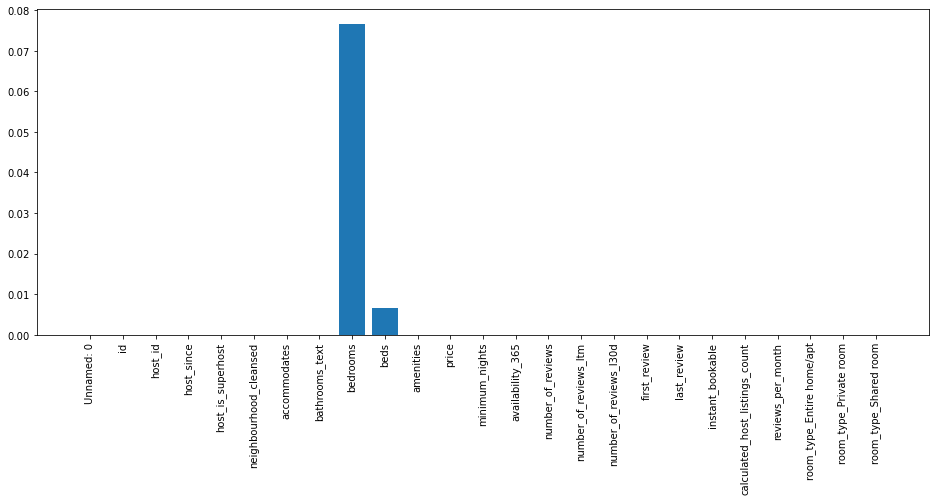

In [14]:
# Looking at the proportion of missing values per feature
d = pd.isnull(myListings_oneHot_v2).sum()
d = {'features' : d.index, 'missing_values': d, 'proportion_missing_values': (d/myListings_oneHot_v2.shape[0])}
d = pd.DataFrame(data=d).reset_index(drop=True)

# Figure representing the proportion of the missing values per feature
plt.figure(figsize=(16,6))
plt.xticks(rotation="vertical")
plt.bar(d.features, d.proportion_missing_values)

In [15]:
#removing irrelevant features
myListings_oneHot_v2 = myListings_oneHot_v2.drop(columns=['Unnamed: 0'])

In [16]:
#Filling the missing values in the numeric features with the median.
for col in myListings_oneHot_v2.columns[myListings_oneHot_v2.isnull().any()]:
    myListings_oneHot_v2[col] = myListings_oneHot_v2[col].fillna(myListings_oneHot_v2[col].median())

In [17]:
#converting host_since, first review, and last review to year 
myListings_oneHot_v2.host_since = pd.to_datetime(myListings_oneHot_v2.host_since)
myListings_oneHot_v2.last_review = pd.to_datetime(myListings_oneHot_v2.last_review)
myListings_oneHot_v2.first_review = pd.to_datetime(myListings_oneHot_v2.first_review)
for i in range(0,len(myListings_oneHot_v2.host_since)):
    myListings_oneHot_v2.host_since[i] = int(myListings_oneHot_v2.host_since[i].year)
    myListings_oneHot_v2.first_review[i] = int(myListings_oneHot_v2.first_review[i].year)
    myListings_oneHot_v2.last_review[i] = int(myListings_oneHot_v2.last_review[i].year)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_l

In [18]:
#labelEncoding of categorical_ordinal features
for ord_cat_feature in ['host_since', 'first_review', 'last_review']:
    myListings_oneHot_v2[ord_cat_feature] = myListings_oneHot_v2[ord_cat_feature].astype('category')
    myListings_oneHot_v2[ord_cat_feature] = myListings_oneHot_v2[ord_cat_feature].cat.codes

In [19]:
#cleaning amenities feature
myListings_oneHot_v2.amenities = myListings_oneHot_v2.amenities.str.replace('[', '')
myListings_oneHot_v2.amenities = myListings_oneHot_v2.amenities.str.replace(']', '')
myListings_oneHot_v2.amenities = myListings_oneHot_v2.amenities.str.replace('\"', '')

<BarContainer object of 24 artists>

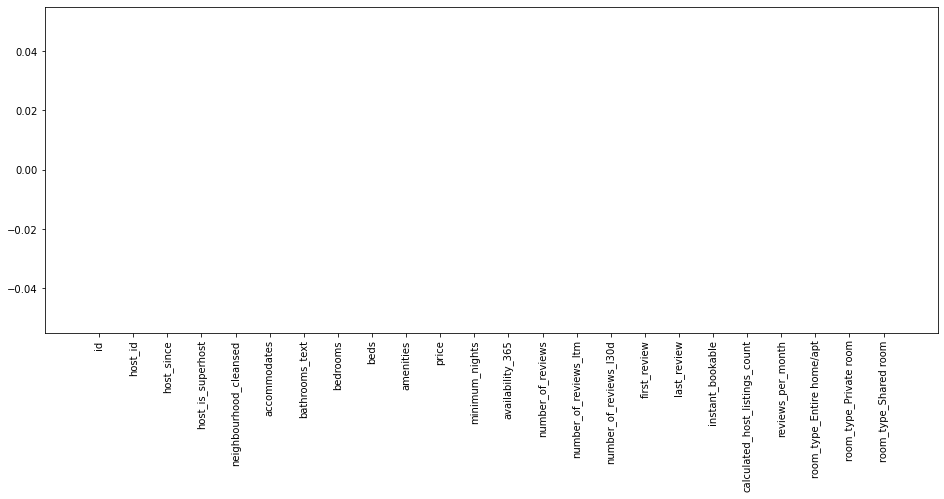

In [20]:
#ensuring there is no missing values 
d = pd.isnull(myListings_oneHot_v2).sum()
d = {'features' : d.index, 'missing_values': d, 'proportion_missing_values': (d/myListings_oneHot_v2.shape[0])}
d = pd.DataFrame(data=d).reset_index(drop=True)

# Figure representing the proportion of the missing values per feature
plt.figure(figsize=(16,6))
plt.xticks(rotation="vertical")
plt.bar(d.features, d.proportion_missing_values)

In [21]:
#merging the listings and the review scores on the listing_id attribute
median_listing_scores = pd.read_csv('median_listing_scores.csv')
myListings_oneHot_v2 = myListings_oneHot_v2.merge(median_listing_scores, left_on='id', right_on = 'listing_id', how='inner')

In [22]:
#sentiment scores to numeric
myListings_oneHot_v2['sentiment_scores_adj'] = pd.to_numeric(myListings_oneHot_v2['sentiment_scores_adj'], errors='coerce')

In [39]:
 myListings_oneHot_v2[['accommodates', 'price', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count',\
                     'sentiment_scores_adj']].describe()

,accommodates,price,minimum_nights,number_of_reviews,calculated_host_listings_count,sentiment_scores_adj
count,9181.000000,9181.000000,9181.000000,9181.000000,9181.000000,9181.000000
mean,3.123625,113.844570,23.557020,40.379806,5.010239,36.515614
std,1.903233,82.817354,30.355241,63.654609,9.324220,21.351499
min,1.000000,13.000000,1.000000,1.000000,1.000000,-66.666667
25%,2.000000,60.000000,5.000000,4.000000,1.000000,25.948592
50%,2.000000,94.000000,28.000000,16.000000,2.000000,33.035714
75%,4.000000,140.000000,28.000000,49.000000,4.000000,41.428571
max,16.000000,650.000000,1000.000000,828.000000,72.000000,300.000000


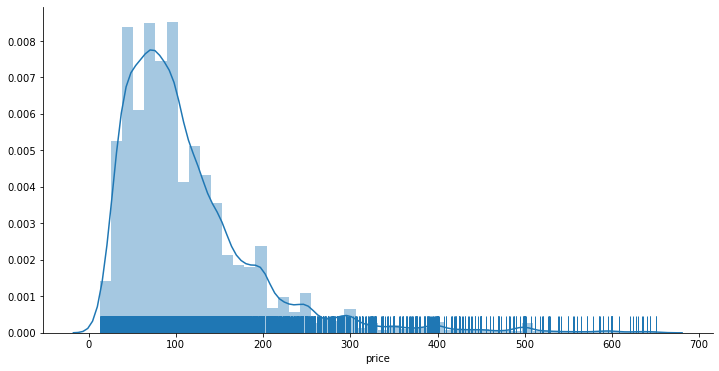

In [28]:
#univariate distributions : price
plt.figure(figsize=(12,6))
sns.distplot(myListings_oneHot_v2.price, rug=True)
sns.despine()
plt.show();

In [23]:
#checking the skewness of the price
from scipy.stats import skew
skew(myListings_oneHot_v2.price, axis=0, bias=False)

2.349026837911659

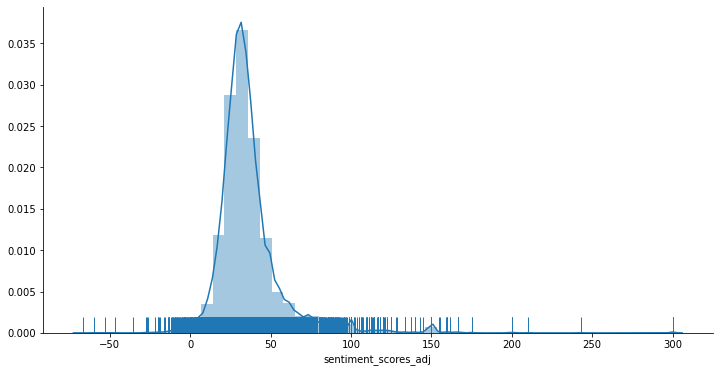

In [24]:
#univariate distributions : sentiment_scores_adj
plt.figure(figsize=(12,6))
sns.distplot(myListings_oneHot_v2.sentiment_scores_adj, rug=True)
sns.despine()
plt.show();

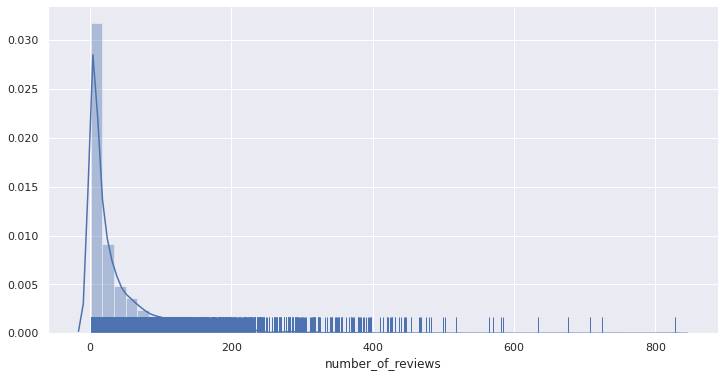

In [59]:
#univariate distributions : number_of_reviews
plt.figure(figsize=(12,6))
sns.distplot(myListings_oneHot_v2.number_of_reviews, rug=True)
sns.despine()
plt.show();

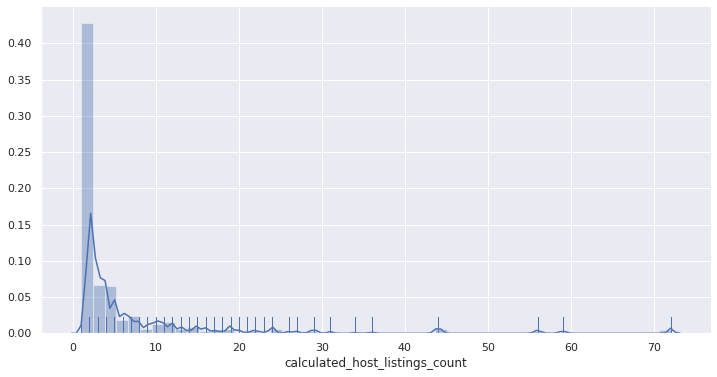

In [60]:
#univariate distributions: host_listings_count
plt.figure(figsize=(12,6))
sns.distplot(myListings_oneHot_v2.calculated_host_listings_count, rug=True)
sns.despine()
plt.show();

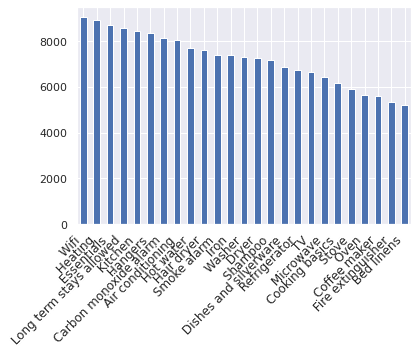

In [61]:
#categorical distributions : the most frequent amenities
pd.Series(np.concatenate(myListings_oneHot_v2['amenities'].map(lambda amns: amns.split(",")))).value_counts().head(25)\
    .plot(kind='bar')
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
plt.show()

In [25]:
#categorical distributions : the most frequent neighborhood_cleansed
myListings_oneHot_v2.groupby(by='neighbourhood_cleansed').count()[['id']].sort_values(by='id', ascending=False).head(20)

,id
neighbourhood_cleansed,
Waterfront Communities-The Island,1602
Niagara,344
Church-Yonge Corridor,314
Annex,291
Bay Street Corridor,255
Trinity-Bellwoods,254
Dovercourt-Wallace Emerson-Junction,247
Moss Park,230
Willowdale East,222


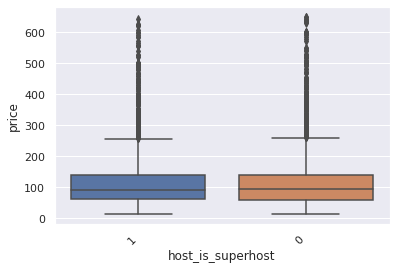

In [63]:
#bivariate price boxplots:host_is_superhost
sort_price = myListings_oneHot_v2\
                    .groupby('host_is_superhost')['price']\
                    .mean()\
                    .sort_values(ascending=False)\
                    .index
sns.boxplot(y='price', x='host_is_superhost', data=myListings_oneHot_v2.loc[(myListings_oneHot_v2.price <= 655)], 
            order=sort_price)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show();

In [64]:
print(myListings_oneHot_v2.groupby('host_is_superhost')['price'].mean())
print(myListings_oneHot_v2.groupby('host_is_superhost')['price'].median())

host_is_superhost
0    112.789809
1    115.533862
Name: price, dtype: float64
host_is_superhost
0    95
1    91
Name: price, dtype: int64


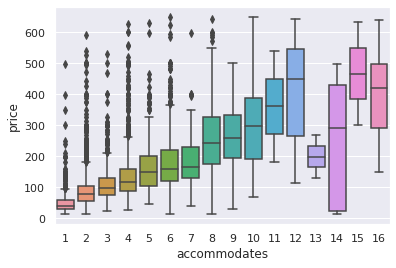

In [65]:
#bivariate price boxplots for numerical features: accommodates
sns.boxplot(y='price', x='accommodates', data = myListings_oneHot_v2)
plt.show()

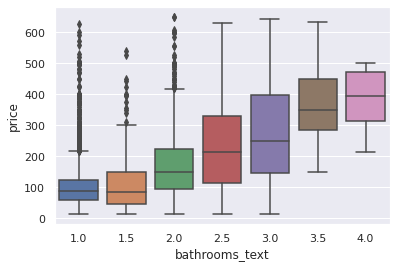

In [66]:
#bivariate price boxplots for numerical features: bathrooms_text
sns.boxplot(y='price', x='bathrooms_text', data = myListings_oneHot_v2)
plt.show()

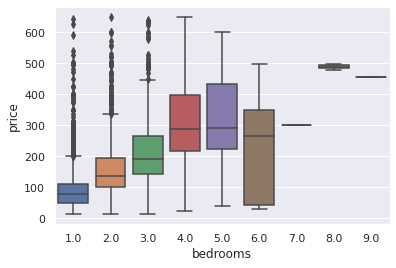

In [67]:
#bivariate price boxplots for numerical features: bedrooms
sns.boxplot(y='price', x='bedrooms', data = myListings_oneHot_v2)
plt.show()

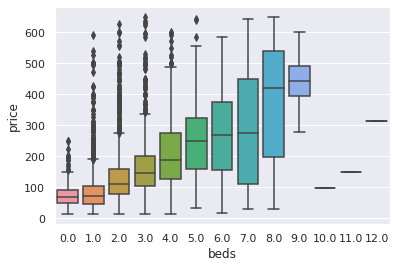

In [68]:
#bivariate price boxplots for numerical features: beds
sns.boxplot(y='price', x='beds', data = myListings_oneHot_v2)
plt.show()

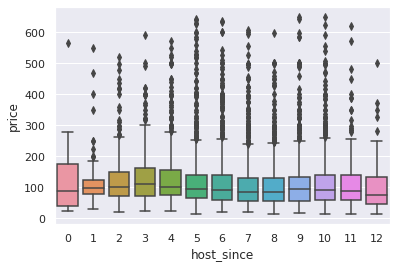

In [69]:
#bivariate price boxplots for numerical features: host_since
sns.boxplot(y='price', x='host_since', data = myListings_oneHot_v2)
plt.show()

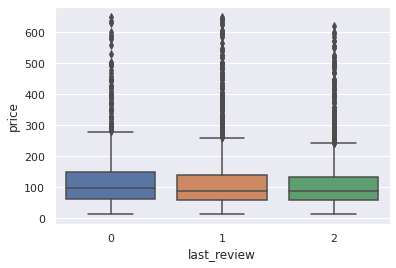

In [70]:
#bivariate price boxplots for numerical features: last_review
sns.boxplot(y='price', x='last_review', data = myListings_oneHot_v2)
plt.show()

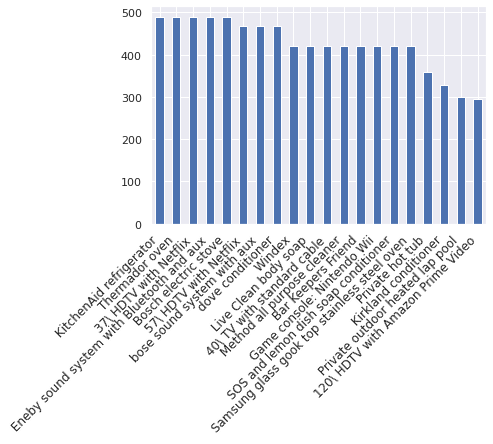

In [71]:
#bivariate price boxplots for categorical features: top 20 amenities
amenities = np.unique(np.concatenate(myListings_oneHot_v2['amenities'].map(lambda amns: amns.split(","))))
amenity_prices = [(amn, myListings_oneHot_v2[myListings_oneHot_v2['amenities'].map(lambda amns: amn in amns)]['price'].mean()) for amn in amenities if amn != ""]
amenity_srs = pd.Series(data=[a[1] for a in amenity_prices], index=[a[0] for a in amenity_prices])
amenity_srs.sort_values(ascending=False)[:20].plot(kind='bar')
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
plt.show()

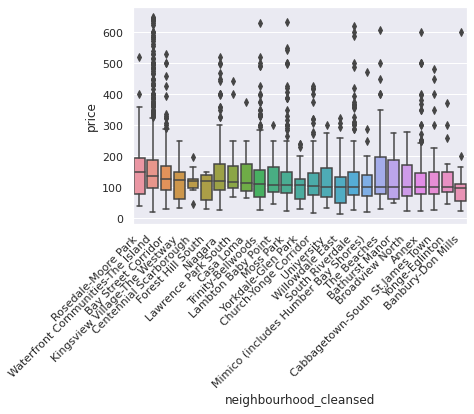

In [72]:
#bivariate price boxplots for numerical features: neighborhood_cleansed _ Top 25
sort_price = myListings_oneHot_v2\
                    .groupby('neighbourhood_cleansed')['price']\
                    .median()\
                    .sort_values(ascending=False)\
                    .index
sns.boxplot(y='price', x='neighbourhood_cleansed', data=myListings_oneHot_v2, 
            order=sort_price[:25])
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show();

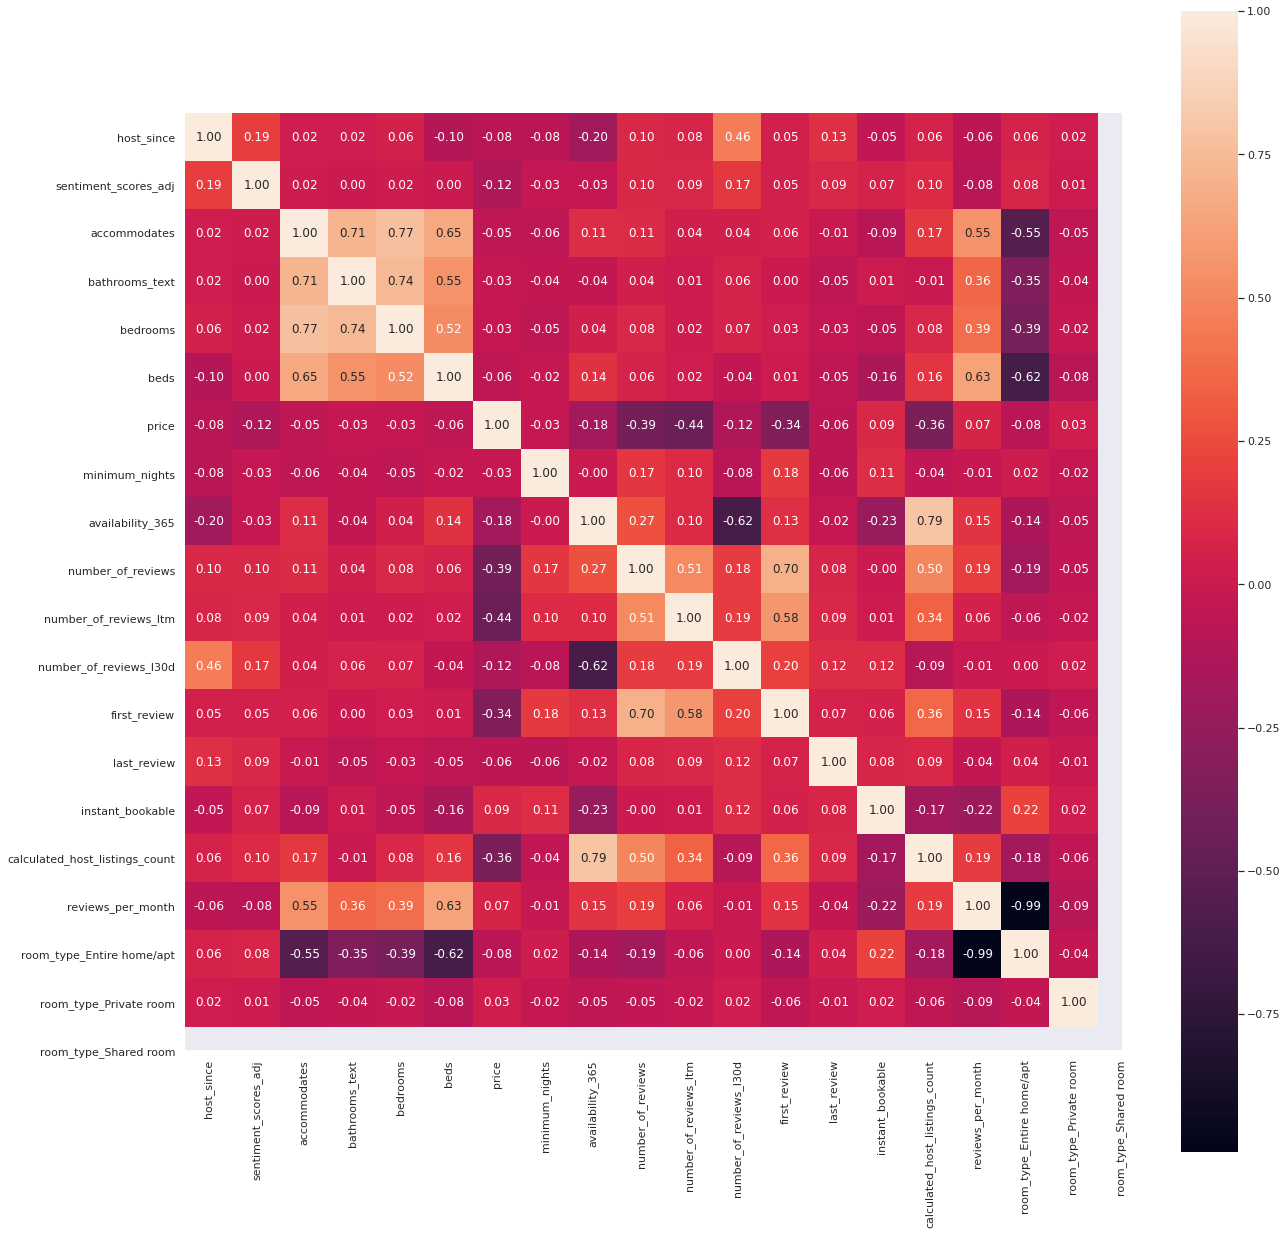

In [73]:
#heatmap of the correlation between the variables
#we will use the 'spearman' method as most of the attributes are discrete

col1 = ['host_since','sentiment_scores_adj','accommodates', 'bathrooms_text', 'bedrooms', 'beds','price', 'minimum_nights', 'availability_365','number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'instant_bookable',\
        'calculated_host_listings_count','reviews_per_month', 'room_type_Entire home/apt', 'room_type_Private room','room_type_Shared room']

corr = myListings_oneHot_v2[myListings_oneHot_v2.host_is_superhost == 1][col1].corr(method = 'spearman')
plt.figure(figsize = (21,21))
sns.set(font_scale=1)
sns.heatmap(corr, cbar = True, annot=True, square = True, fmt = '.2f', xticklabels=col1, yticklabels=col1)
plt.show()

In [26]:
#Feature selection : removing the relatively highly correlated variables
myListings_oneHot_v2 = myListings_oneHot_v2.drop(columns = ['bathrooms_text', 'bedrooms', 'availability_365', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'host_since', \
                                                           'first_review', 'reviews_per_month', 'beds'])


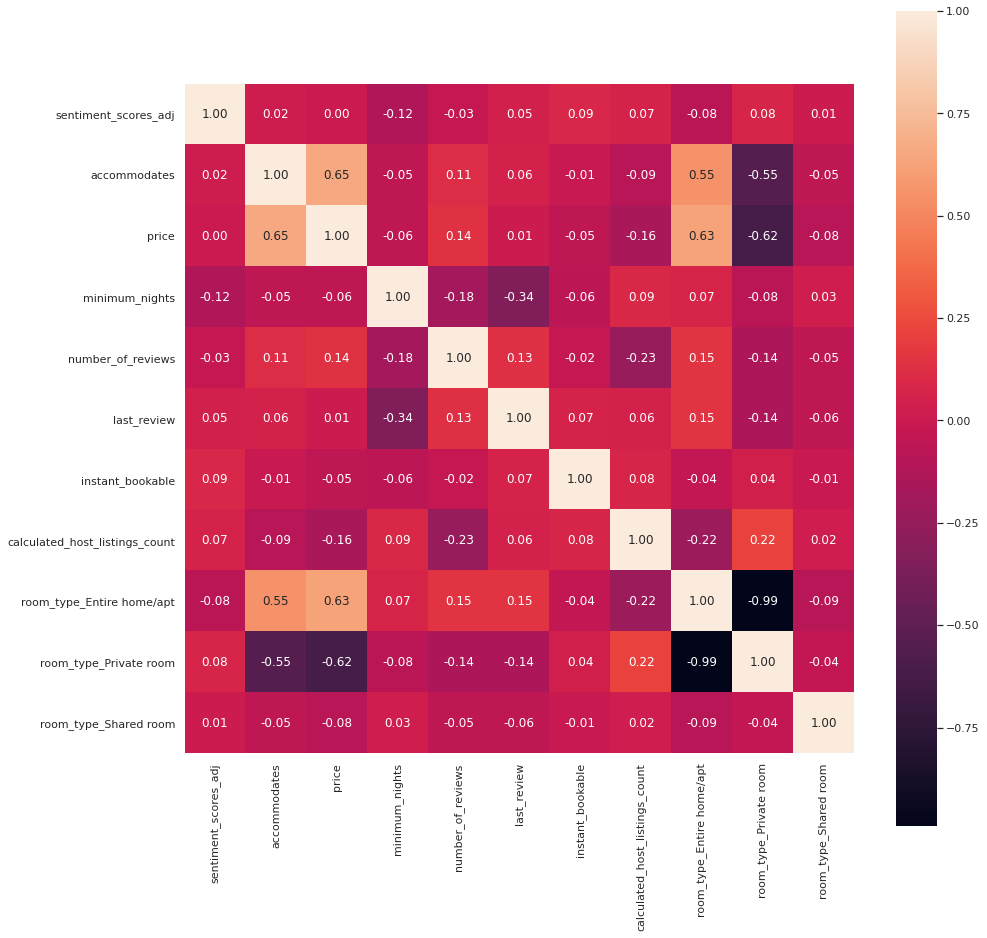

In [27]:
#correlation between the numeric features after feature selection
col2 = ['sentiment_scores_adj','accommodates','price', 'minimum_nights', 'number_of_reviews', 'last_review', 'instant_bookable',\
        'calculated_host_listings_count','room_type_Entire home/apt', 'room_type_Private room','room_type_Shared room']

corr2 = myListings_oneHot_v2[myListings_oneHot_v2.host_is_superhost == 1][col2].corr(method = 'spearman')
plt.figure(figsize = (15,15))
sns.set(font_scale=1)
sns.heatmap(corr2, cbar = True, annot=True, square = True, fmt = '.2f', xticklabels=col2, yticklabels=col2)
plt.show()

In [28]:
#Spearman test of hypothesis : if p > 0.05, we fail to reject the null hypothesis that the variables are uncorrelated
#In this, we will keep these variables
from scipy.stats import spearmanr

for i in range(0, len(myListings_oneHot_v2[myListings_oneHot_v2.host_is_superhost == 1][col2].columns),1):
    for j in range(0, len(myListings_oneHot_v2[myListings_oneHot_v2.host_is_superhost == 1][col2].columns),1):
        
        coef, p = spearmanr(myListings_oneHot_v2[myListings_oneHot_v2.host_is_superhost == 1][col2].iloc[:, [i]], myListings_oneHot_v2[myListings_oneHot_v2.host_is_superhost == 1][col2].iloc[:, [j]])
        if p > 0.05:
            print('p-value between',myListings_oneHot_v2[myListings_oneHot_v2.host_is_superhost == 1][col2].columns[i], 'and', myListings_oneHot_v2[myListings_oneHot_v2.host_is_superhost == 1][col2].columns[j], p)

p-value between sentiment_scores_adj and accommodates 0.2395371695679718
p-value between sentiment_scores_adj and price 0.9634530851247154
p-value between sentiment_scores_adj and number_of_reviews 0.12097821034046026
p-value between sentiment_scores_adj and room_type_Shared room 0.5903965043932631
p-value between accommodates and sentiment_scores_adj 0.23953716956797194
p-value between accommodates and instant_bookable 0.5282505417104861
p-value between price and sentiment_scores_adj 0.9634530851247154
p-value between price and last_review 0.5531590277506034
p-value between minimum_nights and room_type_Shared room 0.0712667492097715
p-value between number_of_reviews and sentiment_scores_adj 0.12097821034046026
p-value between number_of_reviews and instant_bookable 0.19139031986279192
p-value between last_review and price 0.5531590277506034
p-value between instant_bookable and accommodates 0.5282505417104861
p-value between instant_bookable and number_of_reviews 0.19139031986279204
p-v

In [29]:
#Creating dummy amenities
from sklearn.feature_extraction.text import CountVectorizer

myListings_oneHot_v2.amenities = myListings_oneHot_v2.amenities.str.replace("[{}]", "").str.replace('"', "")
count_vectorizer =  CountVectorizer(tokenizer=lambda x: x.split(','))
amenities = count_vectorizer.fit_transform(myListings_oneHot_v2['amenities'])
df_amenities = pd.DataFrame(amenities.toarray(), columns=count_vectorizer.get_feature_names())
df_amenities

,tresemm\u00e9 conditioner,tresemm\u00e9 shampoo,1 space,1. sonos 2. bryston/harbeth 3. rotel/totem sound system with bluetooth and aux,110\ hdtv with chromecast,120\ hdtv with amazon prime video,12\ hdtv with roku,2 spaces,2-5 years old,26\ hdtv with netflix,...,shared indoor heated pool,shared sauna,smart lock,smoke alarm,truly earth shampoo,tv,tv with standard cable,washer,washer \u2013\u00a0in building,washer \u2013\u00a0in unit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9176,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9177,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9178,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9179,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
#creating dummy neighborhood_cleansed
df_neighborhood_cleansed =  pd.get_dummies(myListings_oneHot_v2['neighbourhood_cleansed'])
df_neighborhood_cleansed

,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,Banbury-Don Mills,Bathurst Manor,Bay Street Corridor,Bayview Village,Bayview Woods-Steeles,Bedford Park-Nortown,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9176,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9177,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9178,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9179,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
#Concatenating myListings_oneHot_v2 with neighborhoods
listings_new = pd.concat([myListings_oneHot_v2, df_neighborhood_cleansed], axis=1)

In [32]:
# removing unnecessary attributes to the model 
listings_new = listings_new.drop(columns = ['id','host_id', 'neighbourhood_cleansed', 'amenities', 'listing_id'])
listings_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9181 entries, 0 to 9180
Columns: 151 entries, host_is_superhost to Yorkdale-Glen Park
dtypes: float64(1), int64(10), int8(1), uint8(139)
memory usage: 2.1 MB


In [33]:
#merge listings_new with the amenities dataframe
listings_new_ams = pd.concat([listings_new, df_amenities], axis=1, join='inner')
listings_new_ams

,host_is_superhost,accommodates,price,minimum_nights,number_of_reviews,last_review,instant_bookable,calculated_host_listings_count,room_type_Entire home/apt,room_type_Private room,...,shared indoor heated pool,shared sauna,smart lock,smoke alarm,truly earth shampoo,tv,tv with standard cable,washer,washer \u2013\u00a0in building,washer \u2013\u00a0in unit
0,0,3,72,28,217,0,1,2,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,5,100,30,112,2,0,4,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2,70,28,85,2,0,2,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,4,93,2,31,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,2,101,28,58,2,0,16,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9176,0,3,128,2,1,2,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
9177,0,2,87,1,1,2,0,10,1,0,...,0,0,0,0,0,0,0,0,0,0
9178,0,2,86,1,1,2,0,10,1,0,...,0,0,0,0,0,0,0,0,0,0
9179,0,2,88,1,2,2,0,10,1,0,...,0,0,0,0,0,0,0,0,0,0


In [228]:
listings_new = listings_new.to_csv('listings_new.csv')
listings_new = pd.read_csv('listings_new.csv')

In [34]:
listings_new.columns[:12]

Index(['host_is_superhost', 'accommodates', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'instant_bookable',
       'calculated_host_listings_count', 'room_type_Entire home/apt',
       'room_type_Private room', 'room_type_Shared room',
       'sentiment_scores_adj'],
      dtype='object')

RMSE value for k=  50 is: 67.29100486991265
RMSE value for k=  100 is: 67.07133719463972
RMSE value for k=  150 is: 67.11843994344464
RMSE value for k=  200 is: 66.87548330165063
RMSE value for k=  250 is: 66.82535481660013
RMSE value for k=  300 is: 66.72707663526856
RMSE value for k=  350 is: 66.63231265237792
RMSE value for k=  400 is: 66.64477484964752
RMSE value for k=  450 is: 66.70057995811729
RMSE value for k=  500 is: 66.6525426750853


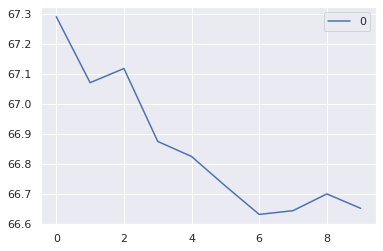

In [29]:
#determining the number of trees (n_estimators)
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

rmse_val = [] 
y = listings_new_ams[listings_new_ams.host_is_superhost == 1]['price']
X = listings_new_ams[listings_new_ams.host_is_superhost == 1].drop(columns = ['price'], axis =1)
X = X.drop(columns = ['host_is_superhost'], axis =1) #X includes the entire features set

for k in range(50, 501, 50):
    
    rf = RandomForestRegressor(n_estimators=k, 
                               criterion='mse', 
                               random_state=0, 
                               max_depth= 10)
       
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1)
   
    rf.fit(X_train, y_train)  
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)
    rmse_rf= (mean_squared_error(y_test,y_test_pred))**(1/2)
    rmse_val.append(rmse_rf) #store rmse values
    print('RMSE value for k= ' , k , 'is:', rmse_rf)
    
  

curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

In [35]:
#1.First RF model: excluding amenities & neighborhood_cleansed
y = listings_new[listings_new.host_is_superhost == 1]['price']
X = listings_new[['host_is_superhost', 'accommodates', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'instant_bookable',
       'calculated_host_listings_count', 'room_type_Entire home/apt',
       'room_type_Private room', 'room_type_Shared room',
       'sentiment_scores_adj']]\
        [listings_new.host_is_superhost == 1].drop(columns = ['price'], axis =1)
X = X.drop(columns = ['host_is_superhost'], axis =1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3529 entries, 2 to 9166
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   accommodates                    3529 non-null   int64  
 1   minimum_nights                  3529 non-null   int64  
 2   number_of_reviews               3529 non-null   int64  
 3   last_review                     3529 non-null   int8   
 4   instant_bookable                3529 non-null   int64  
 5   calculated_host_listings_count  3529 non-null   int64  
 6   room_type_Entire home/apt       3529 non-null   int64  
 7   room_type_Private room          3529 non-null   int64  
 8   room_type_Shared room           3529 non-null   int64  
 9   sentiment_scores_adj            3529 non-null   float64
dtypes: float64(1), int64(8), int8(1)
memory usage: 279.1 KB


In [36]:
#1.1 Random forest: evaluation technique = train/test split

time_start = time.perf_counter() #to compute the execution time to assess the models efficiency


from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1)
rf = RandomForestRegressor(n_estimators=350, 
                               criterion='mse', 
                               random_state=None, 
                               max_depth = 10)
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
rmse_rf11= (mean_squared_error(y_test,y_test_pred))**(1/2)
mae_rf11= mean_absolute_error(y_test,y_test_pred)
r2_score11= r2_score(y_test, y_test_pred)
r2_score11_adj = 1 - ( 1-r2_score11 ) * ( len(y_test) - 1 ) / ( len(y_test) - X_test.shape[1] - 1 )


print('RMSE test: %.3f' % rmse_rf11)
print('MAE test: %.3f' % mae_rf11)
print('R^2 test: %.3f' % r2_score11)
print('R^2 test adjusted: %.3f' % r2_score11_adj)

time_elapsed = (time.perf_counter() - time_start)
print('the execution time is: %.3f' % time_elapsed)

RMSE test: 69.948
MAE test: 44.247
R^2 test: 0.416
R^2 test adjusted: 0.410
the execution time is: 2.235


In [89]:
#After repeating the process 20 times, we get the mean results as following :

rmse_rf11 = 70.0732
mae_rf11 = 44.393
r2_score11 = 0.414
r2_score11_adj = 0.408
execTime_rf11 = 2.253

In [90]:
#feature importances model 1.1: are computed as the mean and standard deviation of accumulation of the 
#impurity decrease within each tree

coefs_df = pd.DataFrame()
coefs_df['attriute'] = X_train.columns
coefs_df['coefficient'] = rf.feature_importances_
coefs_df.sort_values('coefficient', ascending=False).head(10)

,attriute,coefficient
0,accommodates,0.440018
9,sentiment_scores_adj,0.147923
2,number_of_reviews,0.131268
6,room_type_Entire home/apt,0.095657
1,minimum_nights,0.071285
5,calculated_host_listings_count,0.065067
3,last_review,0.026907
4,instant_bookable,0.017765
7,room_type_Private room,0.003994
8,room_type_Shared room,0.000116


In [93]:
#1.2 Random forsest : evaluation technique k-fold cross validation / k=5
#using the cross_val_score procedure: the trainset - validation set will be done automatically

time_start = time.perf_counter()

from sklearn.model_selection import cross_val_score

rmse_rf12 = (np.mean(abs(cross_val_score(RandomForestRegressor(n_estimators=350, 
                               criterion='mse', 
                               random_state=None, 
                               max_depth=10), X, y, cv=5, scoring = 'neg_mean_squared_error'))))**(1/2)

mae_rf12 = np.mean(abs(cross_val_score(RandomForestRegressor(n_estimators=350, 
                               criterion='mse', 
                               random_state=None, 
                               max_depth=10), X, y, cv=5, scoring = 'neg_mean_absolute_error')))

r2_score12 = np.mean(abs(cross_val_score(RandomForestRegressor(n_estimators=350, 
                               criterion='mse', 
                               random_state=None, 
                               max_depth=10), X, y, cv=5, scoring = 'r2')))

r2_score12_adj = 1 - ( 1-r2_score12 ) * ( (len(y)/10) - 1 ) / ( (len(y)/10) - X.shape[1] - 1 )  

print('RMSE test: %.3f' % rmse_rf12)
print('MAE test: %.3f' % mae_rf12)
print('R^2 test: %.3f' % r2_score12)
print('R^2 test adjusted: %.3f' % r2_score12_adj)

time_elapsed = (time.perf_counter() - time_start)
print('the execution time is: %.3f' % time_elapsed)

RMSE test: 69.351
MAE test: 45.078
R^2 test: 0.304
R^2 test adjusted: 0.284
the execution time is: 32.019


In [94]:
execTime_rf12 = 32.019

In [100]:
#2 including the neighborhood_cleansed & excluding amenities
y = listings_new[listings_new.host_is_superhost == 1]['price']
X = listings_new[listings_new.host_is_superhost == 1].drop(columns = ['price'], axis =1)
X = X.drop(columns = ['host_is_superhost'], axis =1)

In [96]:
#2.1 Random Forest : evaluation technique = train/test split

time_start = time.perf_counter()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1)
rf = RandomForestRegressor(n_estimators=350, 
                               criterion='mse', 
                               random_state=None, 
                               max_depth=10)
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
rmse_rf21= (mean_squared_error(y_test,y_test_pred))**(1/2)
mae_rf21= mean_absolute_error(y_test,y_test_pred)
r2_score21= r2_score(y_test, y_test_pred)
r2_score21_adj = 1 - ( 1-r2_score21 ) * ( len(y_test) - 1 ) / ( len(y_test) - X_test.shape[1] - 1 )


print('RMSE test: %.3f' % rmse_rf21)
print('MAE test: %.3f' % mae_rf21)
print('R^2 test: %.3f' % r2_score21)
print('R^2 test adjusted: %.3f' % r2_score21_adj)

time_elapsed = (time.perf_counter() - time_start)
print('the execution time is: %.3f' % time_elapsed)

RMSE test: 67.287
MAE test: 41.331
R^2 test: 0.460
R^2 test adjusted: 0.350
the execution time is: 4.694


In [97]:
#After repeating the process 20 times, we get the mean results as following :
rmse_rf21 = 67.39
mae_rf21 = 41.40
r2_score21 = 0.458
r2_score21_adj = 0.349
execTime_rf21 = 4.575

In [101]:
##feature importance model 2.1
coefs_df = pd.DataFrame()
coefs_df['attriute'] = X_train.columns
coefs_df['coefficient'] = rf.feature_importances_
coefs_df.sort_values('coefficient', ascending=False).head(10)

,attriute,coefficient
0,accommodates,0.444430
6,room_type_Entire home/apt,0.100608
9,sentiment_scores_adj,0.078682
2,number_of_reviews,0.073077
1,minimum_nights,0.046440
5,calculated_host_listings_count,0.045680
3,last_review,0.028959
131,Waterfront Communities-The Island,0.024203
119,South Riverdale,0.019069
51,Etobicoke West Mall,0.016213


In [102]:
#2.2 Random forest : evaluation technique = k-fold cross validation / k=5

time_start = time.perf_counter()

rmse_rf22 = (np.mean(abs(cross_val_score(RandomForestRegressor(n_estimators=350, 
                               criterion='mse', 
                               random_state=None, 
                               max_depth=10), X, y, cv=5, scoring = 'neg_mean_squared_error'))))**(1/2)

mae_rf22 = np.mean(abs(cross_val_score(RandomForestRegressor(n_estimators=350, 
                               criterion='mse', 
                               random_state=None, 
                               max_depth=10), X, y, cv=5, scoring = 'neg_mean_absolute_error')))

r2_score22 = np.mean(abs(cross_val_score(RandomForestRegressor(n_estimators=350, 
                               criterion='mse', 
                               random_state=None, 
                               max_depth=10), X, y, cv=5, scoring = 'r2')))

r2_score22_adj = 1 - ( 1-r2_score22 ) * ( (len(y)/10) - 1 ) / ( (len(y)/10) - X.shape[1] - 1)

print('RMSE test: %.3f' % rmse_rf22)
print('MAE test: %.3f' % mae_rf22)
print('R^2 test: %.3f' % r2_score22)
print('R^2 test adjusted: %.3f' % r2_score22_adj)

time_elapsed = (time.perf_counter() - time_start)
print('the execution time is: %.3f' % time_elapsed)

RMSE test: 66.459
MAE test: 42.197
R^2 test: 0.351
R^2 test adjusted: -0.126
the execution time is: 72.297


In [103]:
execTime_rf22 = 72.297

In [116]:
#3- including the neighborhood_cleansed & amenities
y = listings_new_ams[listings_new_ams.host_is_superhost == 1]['price']
X = listings_new_ams[listings_new_ams.host_is_superhost == 1].drop(columns = ['price'], axis =1)
X = X.drop(columns = ['host_is_superhost'], axis =1)

In [106]:
##3.1 Random forest : evaluation technique = train/test split

time_start = time.perf_counter()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1)
rf = RandomForestRegressor(n_estimators=350, 
                               criterion='mse', 
                               random_state=None, 
                               max_depth=10)
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
rmse_rf31= (mean_squared_error(y_test,y_test_pred))**(1/2)
mae_rf31= mean_absolute_error(y_test,y_test_pred)
r2_score31= r2_score(y_test, y_test_pred)
r2_score31_adj = 1 - ( 1-r2_score31 ) * ( len(y_test) - 1 ) / ( len(y_test) - X_test.shape[1] - 1 )


print('RMSE test: %.3f' % rmse_rf31)
print('MAE test: %.3f' % mae_rf31)
print('R^2 test: %.3f' % r2_score31)
print('R^2 test adjusted: %.3f' % r2_score31_adj)

time_elapsed = (time.perf_counter() - time_start)
print('the execution time is: %.3f' % time_elapsed)

RMSE test: 66.492
MAE test: 39.349
R^2 test: 0.473
R^2 test adjusted: -3.472
the execution time is: 14.315


In [107]:
#After repeating the process 20 times, we get the mean results as following :

rmse_rf31 = 66.709
mae_rf31 = 39.453
r2_score31 = 0.469
r2_score31_adj = -3.501
execTime_rf31 = 14.263 

In [112]:
#feature importances model 3.1
coefs_df = pd.DataFrame()
coefs_df['attribute'] = X_train.columns
coefs_df['coefficient'] = rf.feature_importances_
coefs_df.sort_values('coefficient', ascending=False).head(30)

,attribute,coefficient
0,accommodates,0.390359
6,room_type_Entire home/apt,0.093455
339,dishwasher,0.032630
2,number_of_reviews,0.026463
9,sentiment_scores_adj,0.025282
436,indoor fireplace,0.023791
256,bbq grill,0.020005
1,minimum_nights,0.016242
5,calculated_host_listings_count,0.015783
51,Etobicoke West Mall,0.013025


In [113]:
#3.2 Random forest : evaluation technique = k-fold cross validation / k=5

time_start = time.perf_counter()

rmse_rf32 = (np.mean(abs(cross_val_score(RandomForestRegressor(n_estimators=350, 
                               criterion='mse', 
                               random_state=None, 
                               max_depth=10), X, y, cv=5, scoring = 'neg_mean_squared_error'))))**(1/2)

mae_rf32 = np.mean(abs(cross_val_score(RandomForestRegressor(n_estimators=350, 
                               criterion='mse', 
                               random_state=None, 
                               max_depth=10), X, y, cv=5, scoring = 'neg_mean_absolute_error')))

r2_score32 = np.mean(abs(cross_val_score(RandomForestRegressor(n_estimators=350, 
                               criterion='mse', 
                               random_state=None, 
                               max_depth=10), X, y, cv=5, scoring = 'r2')))

r2_score32_adj = 1 - ( 1-r2_score32 ) * ( (len(y)/10) - 1 ) / ( (len(y)/10) - X.shape[1] - 1)

print('RMSE test: %.3f' % rmse_rf32)
print('MAE test: %.3f' % mae_rf32)
print('R^2 test: %.3f' % r2_score32)
print('R^2 test adjusted: %.3f' % r2_score32_adj)

time_elapsed = (time.perf_counter() - time_start)
print('the execution time is: %.3f' % time_elapsed)

RMSE test: 61.031
MAE test: 38.513
R^2 test: 0.461
R^2 test adjusted: 1.445
the execution time is: 229.163


In [114]:
execTime_rf32 = 229.163

In [116]:
#4. First LR model: excluding amenities & neighborhood_cleansed

y = listings_new[listings_new.host_is_superhost == 1]['price']
X = listings_new[['host_is_superhost', 'accommodates', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'instant_bookable',
       'calculated_host_listings_count', 'room_type_Entire home/apt',
       'room_type_Private room', 'room_type_Shared room',
       'sentiment_scores_adj']]\
        [listings_new.host_is_superhost == 1].drop(columns = ['price'], axis =1)
X = X.drop(columns = ['host_is_superhost'], axis =1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3529 entries, 2 to 9166
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   accommodates                    3529 non-null   int64  
 1   minimum_nights                  3529 non-null   int64  
 2   number_of_reviews               3529 non-null   int64  
 3   last_review                     3529 non-null   int8   
 4   instant_bookable                3529 non-null   int64  
 5   calculated_host_listings_count  3529 non-null   int64  
 6   room_type_Entire home/apt       3529 non-null   int64  
 7   room_type_Private room          3529 non-null   int64  
 8   room_type_Shared room           3529 non-null   int64  
 9   sentiment_scores_adj            3529 non-null   float64
dtypes: float64(1), int64(8), int8(1)
memory usage: 279.1 KB


In [118]:
#4.1 Linear Regression_standars OLS: evaluation technique = train/test split

time_start = time.perf_counter()

from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=None)
lm = LinearRegression()

lm.fit(X_train, y_train)
y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(X_test)
rmse_lm41= (mean_squared_error(y_test,y_test_pred))**(1/2)
mae_lm41= mean_absolute_error(y_test,y_test_pred)
r2_score41= r2_score(y_test, y_test_pred)
r2_score41_adj = 1 - ( 1-r2_score41 ) * ( len(y_test) - 1 ) / ( len(y_test) - X_test.shape[1] - 1 )


print('RMSE test: %.3f' % rmse_lm41)
print('MAE test: %.3f' % mae_lm41)
print('R^2 test: %.3f' % r2_score41)
print('R^2 test adjusted: %.3f' % r2_score41_adj)

time_elapsed = (time.perf_counter() - time_start)
print('the execution time is: %.3f' % time_elapsed)

RMSE test: 66.957
MAE test: 42.529
R^2 test: 0.313
R^2 test adjusted: 0.305
the execution time is: 0.012


In [119]:
#After repeating the process 20 times, we get the mean results as following :

rmse_lm41 = 64.644
mae_lm41 = 41.516
r2_score41 = 0.416
r2_score41_adj = 0.4092
execTime_lm41 = 0.013

In [120]:
print(lm.intercept_)
print(lm.coef_)

#confirming the R^2
print(lm.score(X_test, y_test)) 

28.698229477498828
[ 2.55451484e+01 -5.30682494e-02 -2.08907430e-02 -8.42598633e+00
 -5.54899884e+00  8.27136558e-02  3.27870128e+01 -1.93538545e+00
 -3.08516274e+01  1.79117268e-02]
0.31269410606453873


In [122]:
#4.2 Linear Regression_standars OLS:  evaluation technique = k-fold cross validation / k=5

time_start = time.perf_counter()

rmse_lm42 = (np.mean(abs(cross_val_score(lm, X, y, cv=5, scoring = 'neg_mean_squared_error'))))**(1/2)
mae_lm42 = np.mean(abs(cross_val_score(lm, X, y, cv=5, scoring = 'neg_mean_absolute_error')))
r2_score42 = np.mean(abs(cross_val_score(lm, X, y, cv=5, scoring = 'r2')))
r2_score42_adj = 1 - ( 1-r2_score42 ) * ( (len(y)/10) - 1 ) / ( (len(y)/10) - X.shape[1] - 1 )  

print('RMSE test: %.3f' % rmse_lm42)
print('MAE test: %.3f' % mae_lm42)
print('R^2 test: %.3f' % r2_score42)
print('R^2 test adjusted: %.3f' % r2_score42_adj)

time_elapsed = (time.perf_counter() - time_start)
print('the execution time is: %.3f' % time_elapsed)

RMSE test: 64.175
MAE test: 41.787
R^2 test: 0.413
R^2 test adjusted: 0.396
the execution time is: 0.089


In [172]:
execTime_lm42 = 0.089

In [123]:
#calculating the error terms
df_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})
df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
df_results

,Actual,Predicted,Residuals
3751,149,167.743441,-18.743441
5167,73,62.745462,10.254538
6446,175,256.343723,-81.343723
711,169,105.872428,63.127572
99,80,127.824853,-47.824853
...,...,...,...
7691,83,90.443190,-7.443190
4490,130,119.724670,10.275330
1649,60,179.657363,-119.657363
995,76,119.675170,-43.675170


In [126]:
'''1-Linear relationship between the predictors and the response variable'''

def linear_relationship(model):

           
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
  

    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, height=7)
        
    # Plotting the diagonal line
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.show()

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


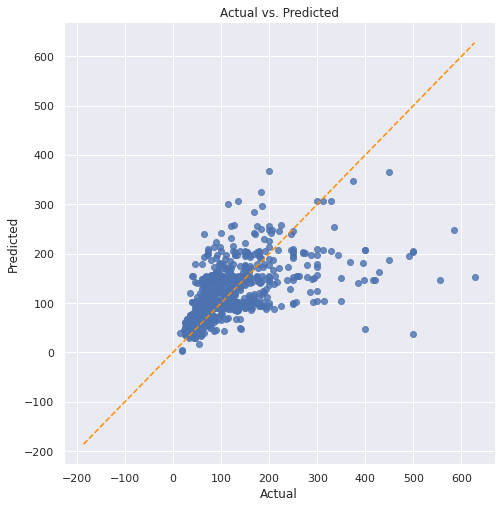

In [127]:
linear_relationship(lm)

In [128]:
'''2-Normality of the error terms'''

def normality_errors(model, p_value_thresh=0.05):

    from statsmodels.stats.diagnostic import normal_ad
   
    # Performing the test on the residuals using the Anderson-Darling test
    p_value = normal_ad(df_results['Residuals'])[1]
    print('p-value from the test (below 0.05 means non-normal) :', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed')
    else:
        print('Residuals are normally distributed')
    
    # Plotting the residuals distribution
    plt.subplots(figsize=(12, 6))
    plt.title('Distribution of Residuals')
    sns.distplot(df_results['Residuals'])
    plt.show()
    
    print()
    if p_value > p_value_thresh:
        print('Assumption satisfied')
    else:
        print('Assumption not satisfied')


p-value from the test (below 0.05 means non-normal) : 0.0
Residuals are not normally distributed


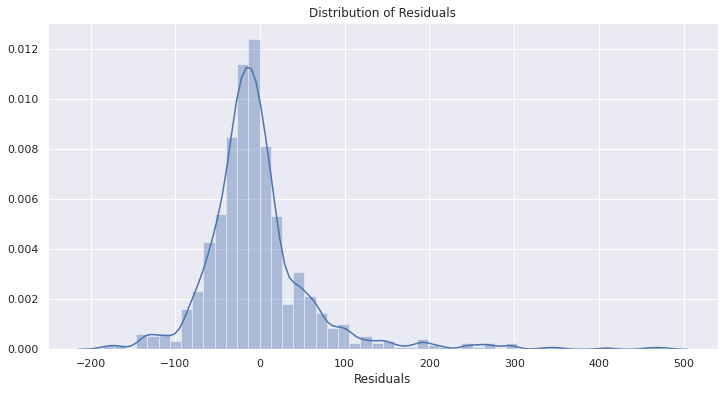


Assumption not satisfied


In [129]:
normality_errors(lm)

In [130]:
'''3-No Multicollinearity among Predictors'''

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,1.254906,accommodates
1,1.048103,minimum_nights
2,1.048863,number_of_reviews
3,1.103526,last_review
4,1.014365,instant_bookable
5,1.022610,calculated_host_listings_count
6,13.001662,room_type_Entire home/apt
7,4.674202,room_type_Private room
8,1.042497,room_type_Shared room
9,1.024004,sentiment_scores_adj


In [131]:
'''4- Independence of the error terms (absence of autocorrelation)'''
#we will use the Durbin-Watson test
#Values of 1.5 < d < 2.5 : no autocorrelation in the data

import statsmodels.stats.stattools
from statsmodels.stats.stattools import durbin_watson
def independence_assumption(model):

    durbinWatson = durbin_watson(df_results['Residuals'])
    print('Durbin-Watson:', durbinWatson)
    if durbinWatson < 1.5:
        print('Signs of positive autocorrelation', '\n')
        print('Assumption not satisfied')
    elif durbinWatson > 2.5:
        print('Signs of negative autocorrelation', '\n')
        print('Assumption not satisfied')
    else:
        print('Little to no autocorrelation', '\n')
        print('Assumption satisfied')

In [132]:
independence_assumption(lm)

Durbin-Watson: 1.9742079446214784
Little to no autocorrelation 

Assumption satisfied


In [137]:
'''5- Homoscedasticity: Assumes that the errors exhibit constant variance'''

def homoscedasticity(model):

    # Plotting the residuals
    plt.subplots(figsize=(12, 6))
    ax = plt.subplot(111)  # To remove spines
    plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
    plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
    ax.spines['right'].set_visible(False)  # Removing the right spine
    ax.spines['top'].set_visible(False)  # Removing the top spine
    plt.title('Residuals')
    plt.show() 

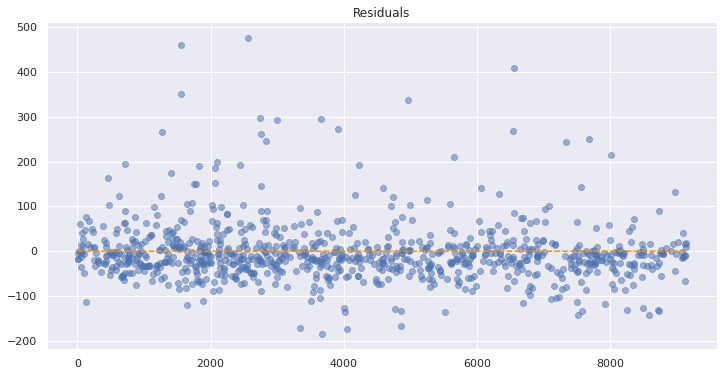

In [138]:
homoscedasticity(lm)

In [139]:
#5- First KNN model: excluding the amenites and the neighborhoods
y = listings_new[listings_new.host_is_superhost == 1]['price']
X = listings_new[['host_is_superhost', 'accommodates', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'instant_bookable',
       'calculated_host_listings_count', 'room_type_Entire home/apt',
       'room_type_Private room', 'room_type_Shared room',
       'sentiment_scores_adj']]\
        [listings_new.host_is_superhost == 1].drop(columns = ['price'], axis =1)
X = X.drop(columns = ['host_is_superhost'], axis =1)

RMSE value for k=  1 is: 96.51492235828404
RMSE value for k=  2 is: 81.55687973394139
RMSE value for k=  3 is: 77.74978985550095
RMSE value for k=  4 is: 76.13989971750733
RMSE value for k=  5 is: 75.64372114148914
RMSE value for k=  6 is: 74.89374525213056
RMSE value for k=  7 is: 74.81866476750102
RMSE value for k=  8 is: 75.00165414370663
RMSE value for k=  9 is: 74.35972766257535
RMSE value for k=  10 is: 74.05352606417068
RMSE value for k=  11 is: 74.11131331280204
RMSE value for k=  12 is: 74.27923452090566
RMSE value for k=  13 is: 74.42173295580803
RMSE value for k=  14 is: 74.17691737685367
RMSE value for k=  15 is: 74.62120808531405
RMSE value for k=  16 is: 74.59921883604729
RMSE value for k=  17 is: 74.71413534585741
RMSE value for k=  18 is: 74.50039335813534
RMSE value for k=  19 is: 74.5701241307832
RMSE value for k=  20 is: 74.3563564240264


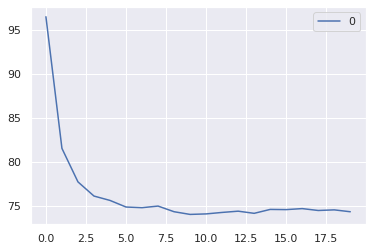

In [168]:
##5.1 KNN: determining k 
from sklearn import neighbors

rmse_val = [] 
for K in range(20):
    K = K+1
    knn = neighbors.KNeighborsRegressor(n_neighbors = K)
       
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=0)
    knn.fit(X_train, y_train)  
    y_train_pred = knn.predict(X_train)
    y_test_pred = knn.predict(X_test)
    rmse_knn51= (mean_squared_error(y_test,y_test_pred))**(1/2)
    rmse_val.append(rmse_knn51) #store rmse values
    print('RMSE value for k= ' , K , 'is:', rmse_knn51)

curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

In [144]:
#5.1 KNN:evaluation technique = train/test split

time_start = time.perf_counter()

from sklearn import neighbors
     
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=None)
knn = neighbors.KNeighborsRegressor(n_neighbors = 10)


knn.fit(X_train, y_train)  
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)
rmse_knn51= (mean_squared_error(y_test,y_test_pred))**(1/2)
mae_knn51= mean_absolute_error(y_test,y_test_pred)
r2_score51= r2_score(y_test, y_test_pred)
r2_score51_adj = 1 - ( 1-r2_score51 ) * ( len(y_test) - 1 ) / ( len(y_test) - X_test.shape[1] - 1 )

print('RMSE test: %.3f' % rmse_knn51)
print('MAE test: %.3f' % mae_knn51)
print('R^2 test: %.3f' % r2_score51)
print('R^2 test adjusted: %.3f' % r2_score51_adj)

time_elapsed = (time.perf_counter() - time_start)
print('the execution time is: %.3f' % time_elapsed)

RMSE test: 78.013
MAE test: 51.574
R^2 test: 0.127
R^2 test adjusted: 0.117
the execution time is: 0.065


In [145]:
#After repeating the process 20 times, we get the mean results as following :

rmse_knn51 = 79.615
mae_knn51 =  52.91
r2_score51 =  0.147
r2_score51_adj = 0.138
execTime_knn51 = 0.066

In [147]:
##5.2 KNN:evaluation technique = k-fold cross validation / k=5

time_start = time.perf_counter()

rmse_knn52 = (np.mean(abs(cross_val_score(knn, X, y, cv=5, scoring = 'neg_mean_squared_error'))))**(1/2)
mae_knn52 = np.mean(abs(cross_val_score(knn, X, y, cv=5, scoring = 'neg_mean_absolute_error')))
r2_score52 = np.mean(abs(cross_val_score(knn, X, y, cv=5, scoring = 'r2')))
r2_score52_adj = 1 - ( 1-r2_score52 ) * ( (len(y)/10) - 1 ) / ( (len(y)/10) - X.shape[1] - 1 )  

print('RMSE test: %.3f' % rmse_knn52)
print('MAE test: %.3f' % mae_knn52)
print('R^2 test: %.3f' % r2_score52)
print('R^2 test adjusted: %.3f' % r2_score52_adj)

time_elapsed = (time.perf_counter() - time_start)
print('the execution time is: %.3f' % time_elapsed)

RMSE test: 78.095
MAE test: 52.166
R^2 test: 0.135
R^2 test adjusted: 0.110
the execution time is: 0.299


In [171]:
execTime_knn52 = 0.295

In [148]:
#6. Second KNN model : including the neighborhood_cleansed & excluding amenities
y = listings_new[listings_new.host_is_superhost == 1]['price']
X = listings_new[listings_new.host_is_superhost == 1].drop(columns = ['price'], axis =1)
X = X.drop(columns = ['host_is_superhost'], axis =1)

In [150]:
#6.1 KNN:evaluation technique = train/test split

time_start = time.perf_counter()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=None)
knn = neighbors.KNeighborsRegressor(n_neighbors = 10)


knn.fit(X_train, y_train)  
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)
rmse_knn61= (mean_squared_error(y_test,y_test_pred))**(1/2)
mae_knn61= mean_absolute_error(y_test,y_test_pred)
r2_score61= r2_score(y_test, y_test_pred)
r2_score61_adj = 1 - ( 1-r2_score61 ) * ( len(y_test) - 1 ) / ( len(y_test) - X_test.shape[1] - 1 )

print('RMSE test: %.3f' % rmse_knn61)
print('MAE test: %.3f' % mae_knn61)
print('R^2 test: %.3f' % r2_score61)
print('R^2 test adjusted: %.3f' % r2_score61_adj)

time_elapsed = (time.perf_counter() - time_start)
print('the execution time is: %.3f' % time_elapsed)

RMSE test: 74.969
MAE test: 51.361
R^2 test: 0.164
R^2 test adjusted: -0.006
the execution time is: 0.629


In [151]:
#After repeating the process 20 times, we get the mean results as following :

rmse_knn61 = 77.321
mae_knn61 = 51.278
r2_score61 = 0.151
r2_score61_adj = -0.02
execTime_knn61 = 0.631

In [153]:
#6.2 KNN:evaluation technique = k-fold cross validation / k=5

time_start = time.perf_counter()

rmse_knn62 = (np.mean(abs(cross_val_score(knn, X, y, cv=5, scoring = 'neg_mean_squared_error'))))**(1/2)
mae_knn62 = np.mean(abs(cross_val_score(knn, X, y, cv=5, scoring = 'neg_mean_absolute_error')))
r2_score62 = np.mean(abs(cross_val_score(knn, X, y, cv=5, scoring = 'r2')))
r2_score62_adj = 1 - ( 1-r2_score52 ) * ( (len(y)/10) - 1 ) / ( (len(y)/10) - X.shape[1] - 1 )  

print('RMSE test: %.3f' % rmse_knn62)
print('MAE test: %.3f' % mae_knn62)
print('R^2 test: %.3f' % r2_score62)
print('R^2 test adjusted: %.3f' % r2_score62_adj)

time_elapsed = (time.perf_counter() - time_start)
print('the execution time is: %.3f' % time_elapsed)

RMSE test: 78.030
MAE test: 52.191
R^2 test: 0.136
R^2 test adjusted: -0.500
the execution time is: 2.399


In [154]:
execTime_knn62 = 2.410

In [155]:
#7- Third KNN model: including the neighborhood_cleansed & amenities
y = listings_new_ams[listings_new_ams.host_is_superhost == 1]['price']
X = listings_new_ams[listings_new_ams.host_is_superhost == 1].drop(columns = ['price'], axis =1)
X = X.drop(columns = ['host_is_superhost'], axis =1)

In [158]:
#7.1 KNN:evaluation technique = train/test split

time_start = time.perf_counter()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=None)
knn = neighbors.KNeighborsRegressor(n_neighbors = 10)


knn.fit(X_train, y_train)  
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)
rmse_knn71= (mean_squared_error(y_test,y_test_pred))**(1/2)
mae_knn71= mean_absolute_error(y_test,y_test_pred)
r2_score71= r2_score(y_test, y_test_pred)
r2_score71_adj = 1 - ( 1-r2_score71 ) * ( len(y_test) - 1 ) / ( len(y_test) - X_test.shape[1] - 1 )

print('RMSE test: %.3f' % rmse_knn71)
print('MAE test: %.3f' % mae_knn71)
print('R^2 test: %.3f' % r2_score71)
print('R^2 test adjusted: %.3f' % r2_score71_adj)

time_elapsed = (time.perf_counter() - time_start)
print('the execution time is: %.3f' % time_elapsed)

RMSE test: 75.875
MAE test: 49.724
R^2 test: 0.178
R^2 test adjusted: -5.971
the execution time is: 3.327


In [159]:
#After repeating the process 20 times, we get the mean results as following :

rmse_knn71 = 79.749
mae_knn71 = 50.889
r2_score71 = 0.164
r2_score71_adj = -6.31
execTime_knn71 = 3.319

In [160]:
#7.2 KNN:evaluation technique = k-fold cross validation / k=5

time_start = time.perf_counter()

rmse_knn72 = (np.mean(abs(cross_val_score(knn, X, y, cv=5, scoring = 'neg_mean_squared_error'))))**(1/2)
mae_knn72 = np.mean(abs(cross_val_score(knn, X, y, cv=5, scoring = 'neg_mean_absolute_error')))
r2_score72 = np.mean(abs(cross_val_score(knn, X, y, cv=5, scoring = 'r2')))
r2_score72_adj = 1 - ( 1-r2_score52 ) * ( (len(y)/10) - 1 ) / ( (len(y)/10) - X.shape[1] - 1 )  

print('RMSE test: %.3f' % rmse_knn72)
print('MAE test: %.3f' % mae_knn72)
print('R^2 test: %.3f' % r2_score72)
print('R^2 test adjusted: %.3f' % r2_score72_adj)

time_elapsed = (time.perf_counter() - time_start)
print('the execution time is: %.3f' % time_elapsed)

RMSE test: 76.940
MAE test: 50.897
R^2 test: 0.160
R^2 test adjusted: 1.714
the execution time is: 14.315


In [162]:
execTime_knn72 = 14.315

RMSE value for k=  10 is: 74.90908369935387
RMSE value for k=  20 is: 61.80075120809677
RMSE value for k=  30 is: 60.72929446583825
RMSE value for k=  40 is: 62.849795998210546
RMSE value for k=  50 is: 63.75287949745353
RMSE value for k=  60 is: 64.97407890290422
RMSE value for k=  70 is: 55.231055494892
RMSE value for k=  80 is: 66.51313868399963
RMSE value for k=  90 is: 59.475118733352964
RMSE value for k=  100 is: 65.77952427692121


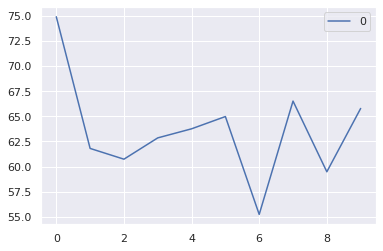

In [205]:
#8. determining the best n_estimators (number of trees)
rmse_val = [] 
y = listings_new_ams[listings_new_ams.host_is_superhost == 1]['price']
X = listings_new_ams[listings_new_ams.host_is_superhost == 1].drop(columns = ['price'], axis =1)
X = X.drop(columns = ['host_is_superhost'], axis =1) 

data_dmatrix = xgb.DMatrix(data=X,label=y)

for k in range(10, 101, 10):
    
    
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1, learning_rate = 0.1,
                max_depth = 10, alpha = 10, n_estimators = k)
       
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=None)
   
    xg_reg.fit(X_train, y_train)  
    y_train_pred = xg_reg.predict(X_train)
    y_test_pred = xg_reg.predict(X_test)
    rmse_xg= (mean_squared_error(y_test,y_test_pred))**(1/2)
    rmse_val.append(rmse_xg) #store rmse values
    print('RMSE value for k= ' , k , 'is:', rmse_xg)
    
  

curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

In [164]:
#8.1 including the amenities and the neighborhoods
y = listings_new_ams[listings_new_ams.host_is_superhost == 1]['price']
X = listings_new_ams[listings_new_ams.host_is_superhost == 1].drop(columns = ['price'], axis =1)
X = X.drop(columns = ['host_is_superhost'], axis =1) 

In [166]:
#8.1 XGboost:evaluation technique = train/test split

time_start = time.perf_counter()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=None)

data_dmatrix = xgb.DMatrix(data=X,label=y)
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1, learning_rate = 0.1,
                max_depth = 10, alpha = 10, n_estimators = 70)

xg_reg.fit(X_train, y_train)  
y_train_pred = xg_reg.predict(X_train)
y_test_pred = xg_reg.predict(X_test)
rmse_xg81= (mean_squared_error(y_test,y_test_pred))**(1/2)
mae_xg81= mean_absolute_error(y_test,y_test_pred)
r2_score81= r2_score(y_test, y_test_pred)
r2_score81_adj = 1 - ( 1-r2_score81 ) * ( len(y_test) - 1 ) / ( len(y_test) - X_test.shape[1] - 1 )

print('RMSE test: %.3f' % rmse_xg81)
print('MAE test: %.3f' % mae_xg81)
print('R^2 test: %.3f' % r2_score81)
print('R^2 test adjusted: %.3f' % r2_score81_adj)

time_elapsed = (time.perf_counter() - time_start)
print('the execution time is: %.3f' % time_elapsed)

RMSE test: 64.633
MAE test: 39.128
R^2 test: 0.474
R^2 test adjusted: -3.463
the execution time is: 4.974


In [167]:
#After repeating the process 20 times, we get the mean results as following :

rmse_xg81 = 63.504
mae_xg81 = 37.3502
r2_score81 = 0.467
r2_score81_adj = -3.511
execTime_xg81 = 4.962


In [169]:
##8.2 XGboost: evaluation technique = k-fold cross validation / k=5

time_start = time.perf_counter()

data_dmatrix = xgb.DMatrix(data=X,label=y)
xg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1, learning_rate = 0.1,
                max_depth = 10, alpha = 10, n_estimators = 70)

rmse_xg82 = (np.mean(abs(cross_val_score(xg, X, y, cv=5, scoring = 'neg_mean_squared_error'))))**(1/2)

mae_xg82 = np.mean(abs(cross_val_score(xg, X, y, cv=5, scoring = 'neg_mean_absolute_error')))

r2_score82 = np.mean(abs(cross_val_score(xg, X, y, cv=5, scoring = 'r2')))

r2_score82_adj = 1 - ( 1-r2_score82 ) * ( (len(y)/10) - 1 ) / ( (len(y)/10) - X.shape[1] - 1 )  

print('RMSE test: %.3f' % rmse_xg82)
print('MAE test: %.3f' % mae_xg82)
print('R^2 test: %.3f' % r2_score82)
print('R^2 test adjusted: %.3f' % r2_score82_adj)

time_elapsed = (time.perf_counter() - time_start)
print('the execution time is: %.3f' % time_elapsed)

RMSE test: 63.350
MAE test: 39.067
R^2 test: 0.424
R^2 test adjusted: 1.475
the execution time is: 77.440


In [170]:
execTime_xg82 = 77.440

In [175]:
MODEL = ['RF1.1', 'RF1.2', 'RF2.1', 'RF2.2', 'RF3.1', 'RF3.2', 'LM4.1', 'LM4.2', 'KNN5.1', 'KNN5.2', 'KNN6.1',\
        'KNN6.2', 'KNN7.1', 'KNN7.2', 'XGboost8.1', 'XGboost8.2']
RMSE = [rmse_rf11, rmse_rf12, rmse_rf21, rmse_rf22, rmse_rf31, rmse_rf32, rmse_lm41, rmse_lm42, rmse_knn51, rmse_knn52,\
       rmse_knn61, rmse_knn62, rmse_knn71, rmse_knn72, rmse_xg81, rmse_xg82]
MAE = [mae_rf11, mae_rf12, mae_rf21, mae_rf22, mae_rf31, mae_rf32, mae_lm41, mae_lm42, mae_knn51, mae_knn52, mae_knn61,\
      mae_knn62, mae_knn71, mae_knn72, mae_xg81, mae_xg82]
Execution_time = [execTime_rf11, execTime_rf12, execTime_rf21, execTime_rf22, execTime_rf31, execTime_rf32,\
                 execTime_lm41, execTime_lm42, execTime_knn51, execTime_knn52, execTime_knn61, execTime_knn62,\
                 execTime_knn71, execTime_knn72, execTime_xg81, execTime_xg82]

RESULTS = pd.DataFrame(
    {'MODEL': MODEL,
     'RMSE': RMSE,
     'MAE': MAE,
     'Execution_time': Execution_time
    })
RESULTS.sort_values(by = 'RMSE')

,MODEL,RMSE,MAE,Execution_time
5,RF3.2,61.030621,38.513456,229.163
15,XGboost8.2,63.350010,39.067468,77.440
14,XGboost8.1,63.504000,37.350200,4.962
7,LM4.2,64.174726,41.787063,0.089
6,LM4.1,64.644000,41.516000,0.013
3,RF2.2,66.458625,42.197432,72.297
4,RF3.1,66.709000,39.453000,14.263
2,RF2.1,67.390000,41.400000,4.575
1,RF1.2,69.350577,45.077613,32.019
0,RF1.1,70.073200,44.393000,2.253


RMSE value for k=  3 is: 61.813763773166286
RMSE value for k=  4 is: 61.787304505101645
RMSE value for k=  5 is: 61.26483259881595
RMSE value for k=  6 is: 61.38398833274411
RMSE value for k=  7 is: 61.82018224477345
RMSE value for k=  8 is: 61.409505299522415
RMSE value for k=  9 is: 61.38536875407887
RMSE value for k=  10 is: 60.87196723560409
RMSE value for k=  11 is: 61.32500454123509
RMSE value for k=  12 is: 60.90290232987636
RMSE value for k=  13 is: 60.784443590386076
RMSE value for k=  14 is: 60.864121688291284


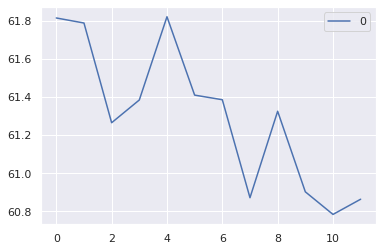

In [267]:
#comparing the RMSE when the k-folds varies

y = listings_new_ams[listings_new_ams.host_is_superhost == 1]['price']
X = listings_new_ams[listings_new_ams.host_is_superhost == 1].drop(columns = ['price'], axis =1)
X = X.drop(columns = ['host_is_superhost'], axis =1)

rmse_val_stab = [] 
for k in range(3, 15, 1):
        
    rmse_stab = (np.mean(abs(cross_val_score(RandomForestRegressor(n_estimators=350, 
                               criterion='mse', 
                               random_state=None, 
                               max_depth=10), X, y, cv=k, scoring = 'neg_mean_squared_error'))))**(1/2)
       
    
    rmse_val_stab.append(rmse_stab) 
    print('RMSE value for k= ' , k , 'is:', rmse_stab)

In [268]:
(max(rmse_val_stab)-min(rmse_val_stab)) / min(rmse_val_stab) *100

1.7039535006144069

In [50]:
#defining the X and y for the superhost subdataset and the non_superhost subdataset
y_superhost = listings_new_ams[listings_new_ams.host_is_superhost == 1]['price']
X_superhost = listings_new_ams[listings_new_ams.host_is_superhost == 1].drop(columns = ['price'], axis =1)
X_superhost = X_superhost.drop(columns = ['host_is_superhost'], axis =1)

y_non_superhost = listings_new_ams[listings_new_ams.host_is_superhost == 0]['price']
X_non_superhost = listings_new_ams[listings_new_ams.host_is_superhost == 0].drop(columns = ['price'], axis =1)
X_non_superhost = X_non_superhost.drop(columns = ['host_is_superhost'], axis =1)

In [51]:
#training the model on the superhost subdataset and predicting the price on the non-superhost subdataset

from sklearn.model_selection import KFold

model = RandomForestRegressor(n_estimators=350, 
                               criterion='mse', 
                               random_state=None, 
                               max_depth=10)
cv = KFold(n_splits=13, random_state=None, shuffle=True) #13 is the optimum number of folds
for train_set, test_set in cv.split(X):
    model.fit(X_superhost.iloc[train_set], y_superhost.iloc[train_set])
    
y_non_superhost_pred = model.predict(X_non_superhost)
print(y_non_superhost_pred)

[ 62.96935133 157.40439179  88.27350656 ... 125.57819724 119.06651136
 114.6327278 ]


In [52]:
#RMSE between the predicted and the actual values of the non_superhosts prices
rmse_non_superhost= (mean_squared_error(y_non_superhost,y_non_superhost_pred))**(1/2)
rmse_non_superhost

63.80411313553884

In [180]:
#checking the mean and median of the actual and predicted prices
import statistics
from statistics import median
from statistics import mean

print('median actual price', median(y_non_superhost))
print('median predicted price', median(y_non_superhost_pred))
print('mean actual price', mean(y_non_superhost))
print('mean predicted price', mean(y_non_superhost_pred))

median actual price 95.0
median predicted price 105.47590797441141
mean actual price 112.78980891719745
mean predicted price 113.52129700739921


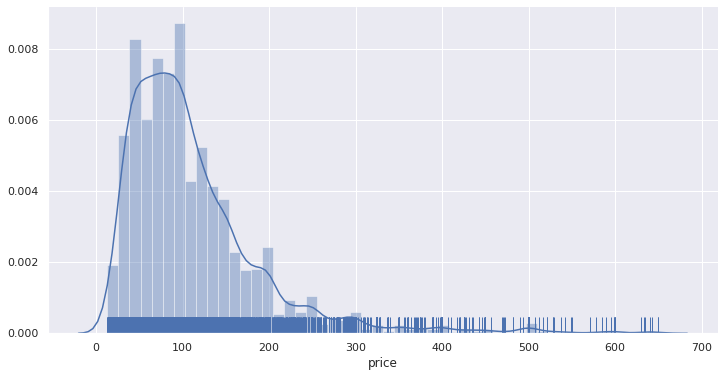

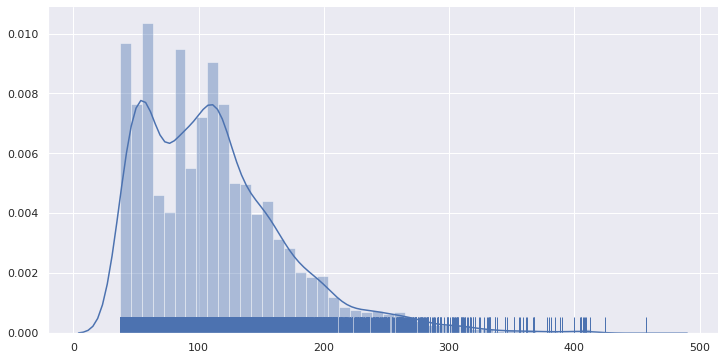

In [183]:
#plotting the actual values of the non_superhosts prices
plt.figure(figsize=(12,6))
sns.distplot(y_non_superhost, rug=True)
sns.despine()
plt.show();

#plotting the predicted values of the non_superhosts prices
plt.figure(figsize=(12,6))
sns.distplot(y_non_superhost_pred, rug=True)
sns.despine()
plt.show();

In [184]:
#testing the normality of actual non_superhost_prices
from scipy.stats import shapiro

stat, p = shapiro(y_non_superhost)
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('the data is normally distributed (fail to reject H0)')
else:
    print('the data is not normally distributed (reject H0)')

Statistics=0.800, p=0.000
the data is not normally distributed (reject H0)


/opt/conda/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [186]:
#testing the normality of predicted non_superhost_prices

stat, p = shapiro(y_non_superhost_pred)
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('the data is normally distributed (fail to reject H0)')
else:
    print('the data is not normally distributed (reject H0)')

Statistics=0.904, p=0.000
the data is not normally distributed (reject H0)


In [187]:
#Mann-Whitney U Test : two-sided
#H0: the two population distributions are identical / Ha: the two population distributions are different

from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(y_non_superhost, y_non_superhost_pred, 
                       use_continuity=True,
                      alternative= 'two-sided')
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
     print('Identical distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Statistics=14586137.000, p=0.000
Different distributions (reject H0)


In [188]:
#Mann-Whitney U Test : one-sided
#H0: the actual non_superhosts price distributions is greater than the predicted for superhosts 
#Ha: the actual non_superhosts price distributions is less than the predicted for superhosts

from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(y_non_superhost, y_non_superhost_pred, 
                       use_continuity=True,
                      alternative= 'less')
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
     print('the actual non_superhosts price distributions is greater than the predicted for superhosts (fail to reject H0)')
else:
    print('the actual non_superhosts price distributions is less than the predicted for superhosts (reject H0)')

Statistics=14586137.000, p=0.000
the actual non_superhosts price distributions is less than the predicted for superhosts (reject H0)


Lambda value used for Transformation: -0.038657697373034636


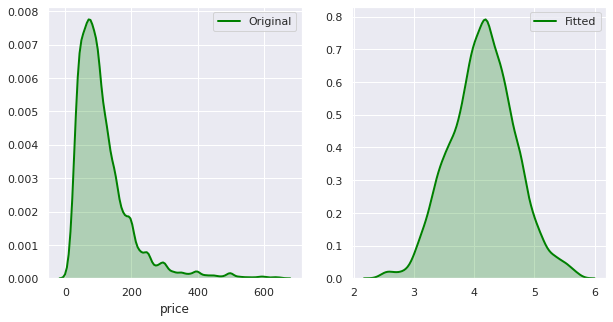

In [120]:
# transform training data & save lambda value
fitted_price, fitted_lambda = stats.boxcox(listings_new_ams.price)

  
# creating axes to draw plots
fig, ax = plt.subplots(1, 2)
  
# plotting the original data(non-normal) 
sns.distplot(listings_new_ams.price, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Original", color ="green", ax = ax[0])

# plotting the fitted data (normal)
sns.distplot(fitted_price, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Fitted", color ="green", ax = ax[1])
  
# adding legends to the subplots
plt.legend(loc = "upper right")
  
# rescaling the subplots
fig.set_figheight(5)
fig.set_figwidth(10)
  
print(f"Lambda value used for Transformation: {fitted_lambda}")

In [121]:
#adding the column 'fitted_price' to the listings_new_ams dataset
listings_new_ams['fitted_price'] = fitted_price
#dropping the original price from the fitted dataset
listings_new_ams_fitted = listings_new_ams.drop(columns= ['price'], axis = 1)

#preparing the X and y of the superhost subdataset and the non_superhost subdataset after fitting the price
y_superhost_fitted = listings_new_ams_fitted[listings_new_ams_fitted.host_is_superhost == 1]['fitted_price']
X_superhost_fitted = listings_new_ams_fitted[listings_new_ams_fitted.host_is_superhost == 1].drop(columns = ['fitted_price'], axis =1)
X_superhost_fitted = X_superhost_fitted.drop(columns = ['host_is_superhost'], axis =1)

y_non_superhost_fitted = listings_new_ams_fitted[listings_new_ams_fitted.host_is_superhost == 0]['fitted_price']
X_non_superhost_fitted = listings_new_ams_fitted[listings_new_ams_fitted.host_is_superhost == 0].drop(columns = ['fitted_price'], axis =1)
X_non_superhost_fitted = X_non_superhost_fitted.drop(columns = ['host_is_superhost'], axis =1)

In [126]:
#training the model on the superhost subdataset based on the fitted_price and predicting the price on the non-superhost subdataset

from sklearn.model_selection import KFold

model = RandomForestRegressor(n_estimators=350, 
                               criterion='mse', 
                               random_state=None, 
                               max_depth=10)
cv = KFold(n_splits=13, random_state=None, shuffle=True) #13 is the optimum number of folds
for train_set, test_set in cv.split(X):
    model.fit(X_superhost_fitted.iloc[train_set], y_superhost_fitted.iloc[train_set])
    
y_non_superhost_pred_fitted = model.predict(X_non_superhost_fitted)


In [129]:
#RMSE between the predicted and the actual values of the non_superhosts fitted prices
rmse_non_superhost_fitted= (mean_squared_error(y_non_superhost_fitted,y_non_superhost_pred_fitted))**(1/2)
print('the RMSE after fitting the price: %.3f' % rmse_non_superhost_fitted)

##MAE between the predicted and the actual values of the non_superhosts fitted prices
mae_non_superhost_fitted = mean_absolute_error(y_non_superhost_fitted,y_non_superhost_pred_fitted)
print('the MAE after fitting the price: %.3f' % mae_non_superhost_fitted)

the RMSE after fitting the price: 0.367
the MAE after fitting the price: 0.281


In [135]:
from scipy.stats import shapiro

stat, p = shapiro(y_non_superhost_fitted)
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('the data is normally distributed (fail to reject H0)')
else:
    print('the data is not normally distributed (reject H0)')

Statistics=0.997, p=0.000
the data is not normally distributed (reject H0)


/opt/conda/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


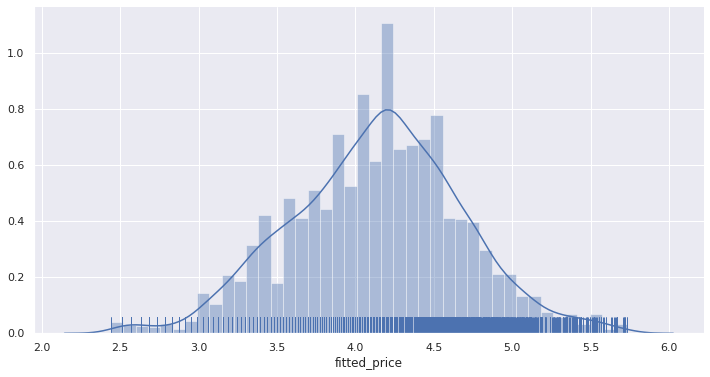

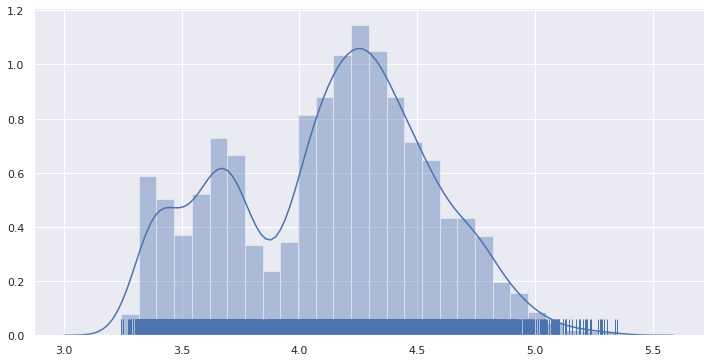

In [130]:
#plotting the actual values of the non_superhosts fitted prices
plt.figure(figsize=(12,6))
sns.distplot(y_non_superhost_fitted, rug=True, label = 'actual')
sns.despine()
plt.show();

#plotting the predicted values of the non_superhosts fitted prices
plt.figure(figsize=(12,6))
sns.distplot(y_non_superhost_pred_fitted, rug=True, label = 'predicted')
sns.despine()
plt.show();

In [131]:
#Mann-Whitney U Test : two-sided
#H0: the two population distributions are identical / Ha: the two population distributions are different

from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(y_non_superhost_fitted, y_non_superhost_pred_fitted, 
                       use_continuity=True,
                      alternative= 'two-sided')
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
     print('Identical distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Statistics=16015826.000, p=0.803
Identical distributions (fail to reject H0)


In [132]:
from scipy.stats import kruskal

kruskal(y_non_superhost_fitted, y_non_superhost_pred_fitted)

KruskalResult(statistic=0.062225625887874406, pvalue=0.8030122114382104)

In [81]:
listings_new_ams_scaled  = listings_new_ams.drop(columns = ['price', 'fitted_price'])

from sklearn.preprocessing import StandardScaler

listings_new_ams_scaled = pd.DataFrame(StandardScaler().fit_transform(listings_new_ams_scaled))

In [86]:
listings_new_ams_scaled

,0,1,2,3,4,5,6,7,8,9,...,769,770,771,772,773,774,775,776,777,778
0,-0.790178,-0.064959,0.146374,2.774816,-1.550439,1.534007,-0.322858,-1.424792,1.460999,-0.105467,...,-0.010437,-0.014761,-0.059141,-0.447886,-0.014761,-0.020878,-0.014761,-0.037656,-0.010437,-0.057257
1,-0.790178,0.985942,0.212264,1.125199,1.189088,-0.651888,-0.108352,0.701857,-0.684463,-0.105467,...,-0.010437,-0.014761,-0.059141,-0.447886,-0.014761,-0.020878,-0.014761,-0.037656,-0.010437,-0.057257
2,1.265538,-0.590409,0.146374,0.701012,1.189088,-0.651888,-0.322858,0.701857,-0.684463,-0.105467,...,-0.010437,-0.014761,-0.059141,-0.447886,-0.014761,-0.020878,-0.014761,-0.037656,-0.010437,-0.057257
3,-0.790178,0.460492,-0.710197,-0.147363,-0.180676,-0.651888,-0.430112,-1.424792,1.460999,-0.105467,...,-0.010437,-0.014761,-0.059141,-0.447886,-0.014761,-0.020878,-0.014761,-0.037656,-0.010437,-0.057257
4,1.265538,-0.590409,0.146374,0.276824,1.189088,-0.651888,1.178690,0.701857,-0.684463,-0.105467,...,-0.010437,-0.014761,-0.059141,-0.447886,-0.014761,-0.020878,-0.014761,-0.037656,-0.010437,-0.057257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9176,-0.790178,-0.064959,-0.710197,-0.618682,1.189088,1.534007,-0.430112,0.701857,-0.684463,-0.105467,...,-0.010437,-0.014761,-0.059141,-0.447886,-0.014761,-0.020878,-0.014761,-0.037656,-0.010437,-0.057257
9177,-0.790178,-0.590409,-0.743142,-0.618682,1.189088,-0.651888,0.535169,0.701857,-0.684463,-0.105467,...,-0.010437,-0.014761,-0.059141,-0.447886,-0.014761,-0.020878,-0.014761,-0.037656,-0.010437,-0.057257
9178,-0.790178,-0.590409,-0.743142,-0.618682,1.189088,-0.651888,0.535169,0.701857,-0.684463,-0.105467,...,-0.010437,-0.014761,-0.059141,-0.447886,-0.014761,-0.020878,-0.014761,-0.037656,-0.010437,-0.057257
9179,-0.790178,-0.590409,-0.743142,-0.602971,1.189088,-0.651888,0.535169,0.701857,-0.684463,-0.105467,...,-0.010437,-0.014761,-0.059141,-0.447886,-0.014761,-0.020878,-0.014761,-0.037656,-0.010437,-0.057257


In [114]:
#PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=430)
principalComponents = pca.fit_transform(listings_new_ams_scaled)
explained_variance = pca.explained_variance_ratio_
#print(explained_variance)

In [138]:
#explained variance
sum_explained_variance = 0
for i in range(0, len(explained_variance),1):
    sum_explained_variance = sum_explained_variance + explained_variance[i]
    i+=1
print(round(sum_explained_variance,3))

0.904
